In [1]:
import os
import torch
import numpy as np
import cv2
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import pytorch_lightning as pl
from diffusers import UNet2DModel, DDPMScheduler
import matplotlib.pyplot as plt
from tqdm import tqdm

# Custom dataset class with pre-computed text images
class CustomDataset(Dataset):
    def __init__(self, image_dir, text_image_dir, transform=None):
        self.image_dir = image_dir
        self.text_image_dir = text_image_dir
        self.filenames = os.listdir(image_dir)
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.filenames[idx])
        text_img_name = os.path.join(self.text_image_dir, self.filenames[idx])

        image = Image.open(img_name).convert("L")  # Convert to grayscale
        text_image = Image.open(text_img_name).convert("L")  # Convert to grayscale

        if self.transform:
            image = self.transform(image)
            text_image = self.transform(text_image)

        return image, text_image

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((64, 2048)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize for grayscale images
])

# Define the dataset and dataloader
image_dir = '/local_dir/Train_Images'  # Adjust to your local directory
text_image_dir = '/local_dir/Transcription_Images'  # Adjust to your local directory
dataset = CustomDataset(image_dir=image_dir, text_image_dir=text_image_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=8)

2024-07-26 23:35:08.638737: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-26 23:35:08.655206: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-26 23:35:08.675059: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-26 23:35:08.681050: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-26 23:35:08.695750: I tensorflow/core/platform/cpu_feature_guar

In [2]:
class SimpleConditionalDDPMWithImage(pl.LightningModule):
    def __init__(self):
        super(SimpleConditionalDDPMWithImage, self).__init__()
        self.model = UNet2DModel(
            sample_size=(64, 2048),
            in_channels=2,  # Update to accept 2 channels (image + text image)
            out_channels=1,
            layers_per_block=2,
            block_out_channels=(64, 128, 256, 512),
            down_block_types=("DownBlock2D", "DownBlock2D", "DownBlock2D", "DownBlock2D"),
            up_block_types=("UpBlock2D", "UpBlock2D", "UpBlock2D", "UpBlock2D")
        )
        self.scheduler = DDPMScheduler(num_train_timesteps=1000)
        self.criterion = torch.nn.MSELoss()

    def forward(self, x, t, text_image):
        # Concatenate image and text image
        x = torch.cat((x, text_image), dim=1)
        return self.model(x, t).sample

    def training_step(self, batch, batch_idx):
        images, text_images = batch
        images = images.to(self.device)
        text_images = text_images.to(self.device)
        t = torch.randint(0, self.scheduler.config.num_train_timesteps, (images.size(0),), device=self.device).long()
        noise = torch.randn_like(images).to(self.device)
        noisy_images = self.scheduler.add_noise(original_samples=images, noise=noise, timesteps=t)
        predicted_noise = self(noisy_images, t, text_images)
        loss = self.criterion(predicted_noise, noise)
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

# Initialize the model with image-based condition
model_with_image = SimpleConditionalDDPMWithImage()

# Define the trainer
trainer_with_image = pl.Trainer(
    accumulate_grad_batches=4,  # Gradient accumulation
    precision=16,  # Mixed precision
    max_epochs=50,  # Continue training for another 50 epochs
    accelerator='gpu',
    devices=1
)

/usr/local/lib/python3.11/dist-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/plugins/precision/amp.py:52: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [7]:
# Train the model with image-based condition
trainer_with_image.fit(model_with_image, dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type        | Params | Mode
-------------------------------------------------
0 | model     | UNet2DModel | 56.6 M | eval
1 | criterion | MSELoss     | 0      | eval
-------------------------------------------------
56.6 M    Trainable params
0         Non-trainable params
56.6 M    Total params
226.291   Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 5/1000 [00:00<00:23, 41.50it/s]

  1%|          | 10/1000 [00:00<00:23, 41.95it/s]

  2%|▏         | 15/1000 [00:00<00:23, 42.31it/s]

  2%|▏         | 20/1000 [00:00<00:23, 42.43it/s]

  2%|▎         | 25/1000 [00:00<00:23, 42.22it/s]

  3%|▎         | 30/1000 [00:00<00:23, 42.05it/s]

  4%|▎         | 35/1000 [00:00<00:22, 42.05it/s]

  4%|▍         | 40/1000 [00:00<00:22, 41.81it/s]

  4%|▍         | 45/1000 [00:01<00:22, 42.19it/s]

  5%|▌         | 50/1000 [00:01<00:22, 42.22it/s]

  6%|▌         | 55/1000 [00:01<00:22, 42.19it/s]

  6%|▌         | 60/1000 [00:01<00:22, 42.22it/s]

  6%|▋         | 65/1000 [00:01<00:22, 42.29it/s]

  7%|▋         | 70/1000 [00:01<00:21, 42.39it/s]

  8%|▊         | 75/1000 [00:01<00:21, 42.57it/s]

  8%|▊         | 80/1000 [00:01<00:21, 42.35it/s]

  8%|▊         | 85/1000 [00:02<00:21, 42.35it/s]

  9%|▉         | 90/1000 [00:02<00:21, 42.30it/s]

 

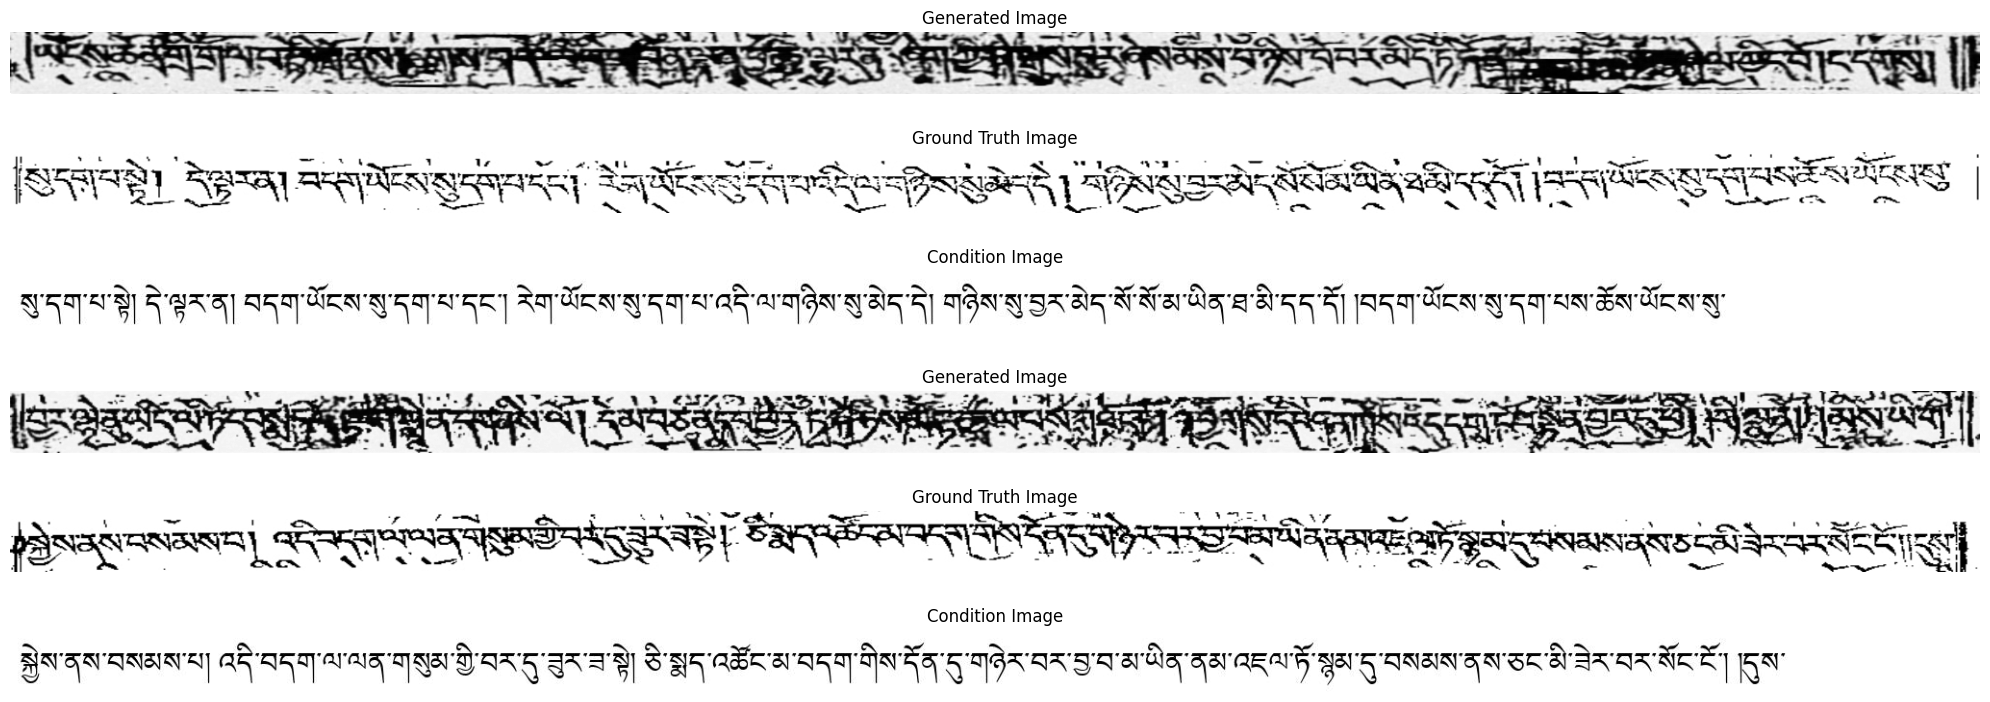

In [9]:
import random
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

# Function to generate conditional images from noise using a random text image from training data
def generate_conditional_images(model, scheduler, dataset, num_images=8, device='cuda'):
    model.to(device)  # Ensure model is on the correct device
    model.eval()
    fig, axs = plt.subplots(3 * num_images, 1, figsize=(20, 7.5))
    with torch.no_grad():
        for i in tqdm(range(num_images)):
            # Select a random image and text image pair from the dataset
            random_idx = random.randint(0, len(dataset) - 1)
            image, random_text_image = dataset[random_idx]
            random_text_image = random_text_image.to(device).unsqueeze(0)
            noise = torch.randn((1, 1, 64, 2048)).to(device)
            for t in tqdm(range(scheduler.config.num_train_timesteps - 1, -1, -1), leave=False):
                t_tensor = torch.tensor([t], device=device).long()
                predicted_noise = model(noise, t_tensor, random_text_image)
                noise = scheduler.step(model_output=predicted_noise, timestep=t_tensor, sample=noise).prev_sample

            # Display the generated image
            axs[3 * i].imshow(noise.squeeze().cpu().numpy(), cmap='gray')
            axs[3 * i].set_title("Generated Image")
            axs[3 * i].axis('off')

            # Display the ground truth image
            axs[3 * i + 1].imshow(image.permute(1, 2, 0).cpu().numpy(), cmap='gray')
            axs[3 * i + 1].set_title("Ground Truth Image")
            axs[3 * i + 1].axis('off')

            # Display the condition image
            axs[3 * i + 2].imshow(random_text_image.squeeze().cpu().numpy(), cmap='gray')
            axs[3 * i + 2].set_title("Condition Image")
            axs[3 * i + 2].axis('off')

    plt.tight_layout()
    plt.show()

# Generate and display conditional images using random text images from the training data
generate_conditional_images(model_with_image, model_with_image.scheduler, dataset, num_images=2, device='cuda')

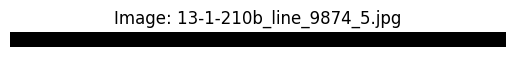

In [11]:
import os
from PIL import Image
import matplotlib.pyplot as plt

def display_image(image_path):
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        return

    image = Image.open(image_path)
    plt.imshow(image, cmap='gray')
    plt.title(f"Image: {os.path.basename(image_path)}")
    plt.axis('off')
    plt.show()

# Example usage
image_path = '/local_dir/Transcription_Images/13-1-210b_line_9874_5.jpg'  # Replace with your image path
display_image(image_path)